In [2]:
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
import cv2
import pickle
import pylab
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import Model
from skimage.io import imsave, imread
from PIL import Image
from losses import bce_dice_loss, dice_loss, dice_coeff
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [80]:
#Collecting training data

dir_= os.listdir('train')
total = len(dir_)
channels=3
imgs = np.ndarray((total, 224 , 224,channels), dtype=np.uint8)
i=0
for files in tqdm(dir_):
    path= 'train/' + files
    img= imread(path)
    img= cv2.resize(img,(224,224))
    img=np.asarray([img])
    imgs[i] = img
    i+=1
   
    

100%|██████████████████████████████████████████████████████████████████████████████| 5088/5088 [03:45<00:00, 22.54it/s]


In [81]:
print(imgs.shape)
print(imgs[0].shape)

(5088, 224, 224, 3)
(224, 224, 3)


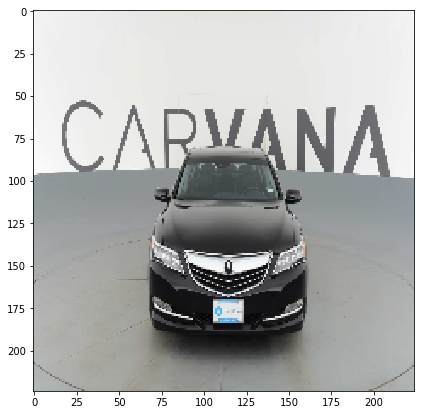

In [82]:
plt.figure(figsize = (15, 7))
plt.imshow(imgs[0])
plt.show()

In [83]:
#Collecting masks
total = len(os.listdir('train_masks'))
channels=1
masks = np.ndarray((total, 224 , 224,channels), dtype=np.uint8)
i=0
for files in tqdm(os.listdir('train_masks')):
    path= 'train_masks/' + files
    mask= imread(path)
    mask= cv2.resize(mask,(224,224))
    mask=np.asarray([mask])
    mask = np.expand_dims(mask, axis=3)
    masks[i] = mask
    i+=1

100%|██████████████████████████████████████████████████████████████████████████████| 5088/5088 [02:24<00:00, 35.15it/s]


In [84]:
print(masks.shape)
print(masks[0].shape)

(5088, 224, 224, 1)
(224, 224, 1)


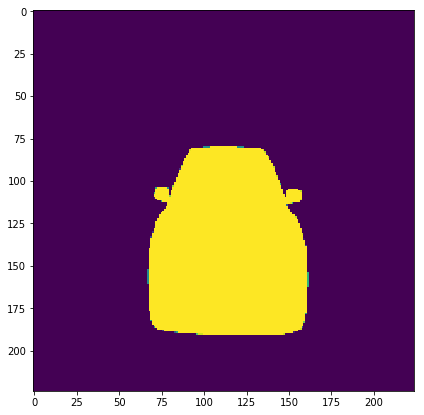

In [85]:
plt.figure(figsize = (15, 7))
plt.imshow(masks[0].reshape(224,224))
plt.show()

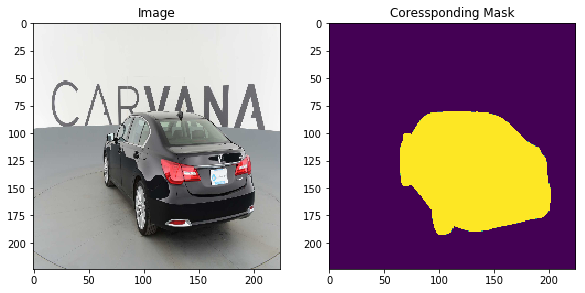

In [86]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(imgs[7])
plt.subplot(1,3,2)
plt.title('Coressponding Mask')
plt.imshow(masks[7].reshape(224,224))
plt.show()

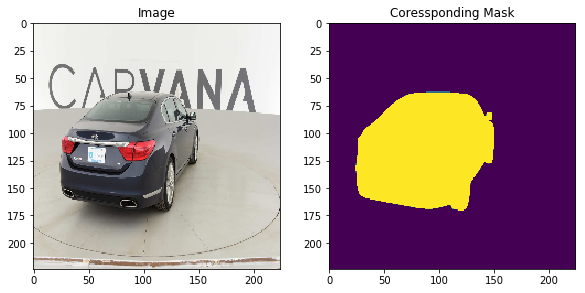

In [87]:
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(imgs[3001])
plt.subplot(1,3,2)
plt.title('Coressponding Mask')
plt.imshow(masks[3001].reshape(224,224))
plt.show()

In [11]:
masks = masks/255.

In [12]:
#np.save('masks.npy', masks)

In [13]:
imgs=imgs/255.

In [14]:
#np.save('imgs.npy', imgs)

In [15]:
len(masks)

5088

In [16]:
len(imgs)*.2

1017.6

In [17]:
train_img, val_img= imgs[:4070], imgs[4070:]

In [18]:
train_mask, val_mask = masks[:4070], masks[4070:]

In [3]:
initial_model =VGG16(weights='imagenet')

In [4]:
for i in range(0,5):
    
    initial_model.layers.pop()
    initial_model = Model(inputs=initial_model.inputs, outputs=initial_model.layers[-1].output)
initial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
last = initial_model.output
#up4=BatchNormalization()(last)
up4 = UpSampling2D((2, 2))(last)
up4 = concatenate([initial_model.get_layer('block4_conv3').output, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same',activation='relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same',activation='relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same',activation='relu')(up4)
#up3=BatchNormalization()(up4)
up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([initial_model.get_layer('block3_conv3').output,up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same',activation='relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same',activation='relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same',activation='relu',name='conv9')(up3)
#up2=BatchNormalization()(up3)
up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([initial_model.get_layer('block2_conv2').output, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same',activation='relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same',activation='relu')(up2)
#up1=BatchNormalization()(up2)

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([initial_model.get_layer('block1_conv2').output, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same',activation='relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same',activation='relu')(up1)
#up1=BatchNormalization()(up1)

classify = Conv2D(1, (1, 1), activation='sigmoid')(up1)



model = Model(initial_model.input, classify)


In [6]:
for i,k in enumerate(model.layers):
    print(i,k.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 up_sampling2d_1
19 concatenate_1
20 conv2d_1
21 conv2d_2
22 conv2d_3
23 up_sampling2d_2
24 concatenate_2
25 conv2d_4
26 conv2d_5
27 conv9
28 up_sampling2d_3
29 concatenate_3
30 conv2d_6
31 conv2d_7
32 up_sampling2d_4
33 concatenate_4
34 conv2d_8
35 conv2d_9
36 conv2d_10


In [7]:
for layer in model.layers[:18]:
    layer.trainable = False

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [9]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [10]:
model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

In [28]:
# fit model
model.fit(train_img, train_mask, epochs=50, verbose=2, callbacks=callbacks, validation_data=(val_img,val_mask), batch_size=4)

Train on 4070 samples, validate on 1018 samples
Epoch 1/50
 - 437s - loss: 0.0642 - dice_coeff: 0.9703 - val_loss: 0.0245 - val_dice_coeff: 0.9881
Epoch 2/50
 - 431s - loss: 0.0197 - dice_coeff: 0.9899 - val_loss: 0.0181 - val_dice_coeff: 0.9909
Epoch 3/50
 - 432s - loss: 0.0163 - dice_coeff: 0.9916 - val_loss: 0.0180 - val_dice_coeff: 0.9915
Epoch 4/50
 - 431s - loss: 0.0145 - dice_coeff: 0.9925 - val_loss: 0.0160 - val_dice_coeff: 0.9922
Epoch 5/50
 - 431s - loss: 0.0134 - dice_coeff: 0.9931 - val_loss: 0.0160 - val_dice_coeff: 0.9924
Epoch 6/50
 - 431s - loss: 0.0124 - dice_coeff: 0.9936 - val_loss: 0.0153 - val_dice_coeff: 0.9929
Epoch 7/50
 - 431s - loss: 0.0116 - dice_coeff: 0.9940 - val_loss: 0.0156 - val_dice_coeff: 0.9928
Epoch 8/50
 - 431s - loss: 0.0110 - dice_coeff: 0.9943 - val_loss: 0.0158 - val_dice_coeff: 0.9930
Epoch 9/50
 - 431s - loss: 0.0104 - dice_coeff: 0.9946 - val_loss: 0.0157 - val_dice_coeff: 0.9932
Epoch 10/50
 - 431s - loss: 0.0099 - dice_coeff: 0.9949 - val

In [32]:
model.save_weights('Image_masking.h5')

In [11]:
model.load_weights('Image_masking.h5')

In [37]:
#Collecting test images
test_data=os.listdir('test')
total = len(test_data)
sub = int(total/100)
channels=3
test_img = np.ndarray((sub, 224 , 224,channels), dtype=np.uint8)
i=0
for files in tqdm(test_data[:sub]):
    path= 'test/' + files
    img= imread(path)
    img= cv2.resize(img,(224,224))
    img=np.asarray([img])
    test_img[i] = img
    i+=1

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.91it/s]


In [39]:
test_img= test_img/255.

In [76]:
test_img.shape

(1000, 224, 224, 3)

In [47]:
pred= model.predict(test_img[:10])

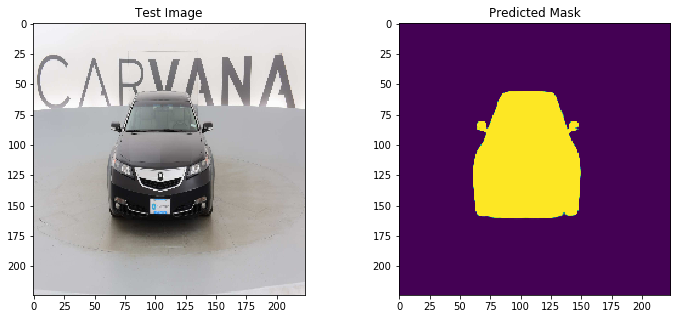

In [71]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(test_img[0])
plt.subplot(1,2,2)
plt.title('Predicted Mask')
plt.imshow((pred[0]/255.).reshape(224,224))
plt.show()

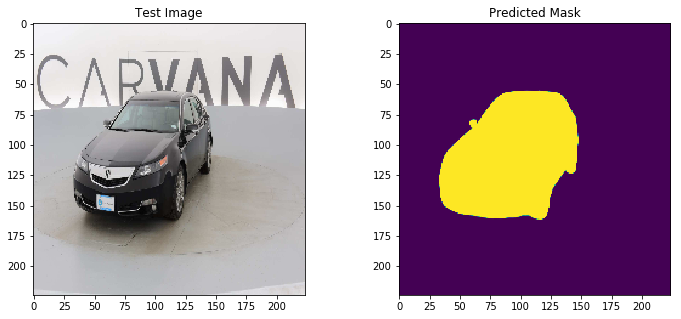

In [72]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(test_img[1])
plt.subplot(1,2,2)
plt.title('Predicted Mask')
plt.imshow((pred[1]/255.).reshape(224,224))
plt.show()

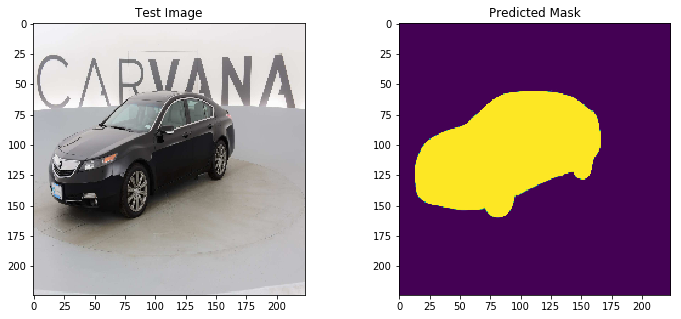

In [74]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(test_img[2])
plt.subplot(1,2,2)
plt.title('Predicted Mask')
plt.imshow((pred[2]/255.).reshape(224,224))
plt.show()

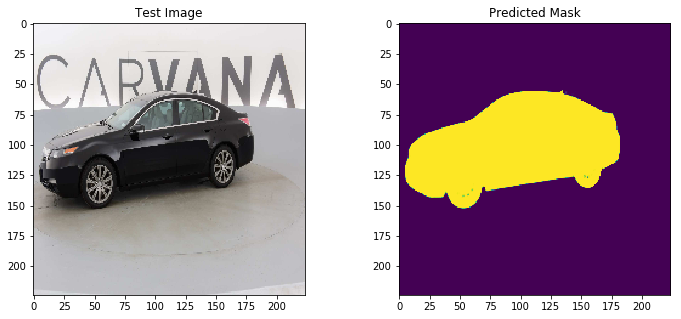

In [88]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(test_img[3])
plt.subplot(1,2,2)
plt.title('Predicted Mask')
plt.imshow((pred[3]/255.).reshape(224,224))
plt.show()

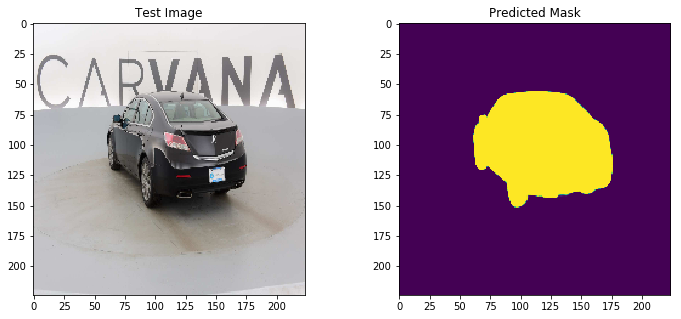

In [90]:
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
plt.title('Test Image')
plt.imshow(test_img[7])
plt.subplot(1,2,2)
plt.title('Predicted Mask')
plt.imshow((pred[7]/255.).reshape(224,224))
plt.show()